# Probabilistic Partial Least Squares

PPLS is take to data, comparing it with standard PLS in two ways:
* Simulation 1: Generate synthetic data and compare the fit of all models
* Simulation 2: Generate synthetic data with additional noise and compare the fit of all models
* Simulation 3: Generate synthetic data with missing observations and compare to PLS on imputed data

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, sparse
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression
from PPLS import generate_synthetic_data, ProbabilisticPLS, ProbabilisticPLS_Old

# Generate synthetic data
seed_value = None
n, p, q, k = 100, 5, 3, 2
true_sigma_x, true_sigma_y = 1.0, 1.0
X, Y, T, P_true, Q_true = generate_synthetic_data(n, p, q, k, true_sigma_x, true_sigma_y, seed_value)

# Apply PLS regression
pls = PLSRegression(n_components=k)
pls.fit(X, Y)
Y_pred_pls = pls.predict(X)

# Apply PPLS
ppls_model = ProbabilisticPLS_Old(n_components=k)
ppls_model.fit(X, Y)
Y_pred_ppls = ppls_model.predict(X)

# Apply stacked PPLS
predict_method = "mean"
prediction_variance = False
stacked_model_standardized = ProbabilisticPLS(n_components=k)
stacked_model_standardized.fit(X, Y, standardize = True, track_r2 = True)
Y_fitted_stacked_standardized = stacked_model_standardized.fitted(X, Y, standardize = False)
Y_fitted_stacked_doublestandardized = stacked_model_standardized.fitted(X, Y, standardize = True)
Y_pred_stacked_standardized = stacked_model_standardized.predict(X, standardize = False, method = predict_method)
Y_pred_stacked_doublestandardized = stacked_model_standardized.predict(X, standardize = True, method = predict_method)
stacked_model_raw = ProbabilisticPLS(n_components=k)
stacked_model_raw.fit(X, Y, standardize = False, track_r2 = True)
Y_fitted_stacked_raw = stacked_model_raw.fitted(X, Y, standardize = False)
Y_pred_stacked_raw = stacked_model_raw.predict(X, standardize = False, method = predict_method)

# Compute R-squared for all models and compare them
r2_pls = r2_score(Y, Y_pred_pls, multioutput = "raw_values")
r2_ppls = r2_score(Y, Y_pred_ppls, multioutput = "raw_values")
r2_stacked_standardized = r2_score(Y, Y_fitted_stacked_standardized, multioutput = "raw_values")
r2_stacked_doublestandardized = r2_score(Y, Y_fitted_stacked_doublestandardized, multioutput = "raw_values")
r2_loading_standardized = r2_score(Y, Y_pred_stacked_standardized, multioutput = "raw_values")
r2_loading_doublestandardized = r2_score(Y, Y_pred_stacked_doublestandardized, multioutput = "raw_values")
r2_stacked_raw = r2_score(Y, Y_fitted_stacked_raw, multioutput = "raw_values")
r2_loading_raw = r2_score(Y, Y_pred_stacked_raw, multioutput = "raw_values")
r2_results = {"pls": r2_pls, "ppls": r2_ppls, "stacked_raw": r2_stacked_raw, "loading_raw": r2_loading_raw,
              "stacked_standardized": r2_stacked_standardized, "stacked_doublestandardized": r2_stacked_doublestandardized,
              "loading_standardized": r2_loading_standardized, "loading_doublestandardized": r2_loading_doublestandardized}

# Print true values and estimated parameters for comparison
print("True P:\n", P_true)
print("True Q:\n", Q_true)
print("PLS Regression Coefficients:\n", pls.coef_)
print("PLS Loadings X:\n", pls.x_loadings_)
print("PLS Loadings Y:\n", pls.y_loadings_)
print("Estimated P (PPLS):\n", ppls_model.P_)
print("Estimated Q (PPLS):\n", ppls_model.Q_)
print("Estimated P (Stacked PPLS):\n", stacked_model_raw.P_)
print("Estimated Q (Stacked PPLS):\n", stacked_model_raw.Q_)

print("True sigma_x:", true_sigma_x)
print("True sigma_y:", true_sigma_y)
print("Estimated sigma_x (PPLS):", np.sqrt(ppls_model.sigma_x_))
print("Estimated sigma_y (PPLS):", np.sqrt(ppls_model.sigma_y_))
print("Estimated sigma_x (Stacked PPLS):", np.sqrt(stacked_model_raw.sigma2_x_))
print("Estimated sigma_y (Stacked PPLS):", np.sqrt(stacked_model_raw.sigma2_y_))

print(r2_results)

print(X)
print(np.ravel(X).reshape([n, p]))

True P:
 [[-0.29316234 -1.1140596 ]
 [-0.28248801  0.70490724]
 [ 0.8868999  -0.39691027]
 [ 0.94544498 -0.18705465]
 [ 0.66372438 -2.07152464]]
True Q:
 [[0.06036819 1.89152451]
 [1.51781641 0.78798288]
 [1.3878589  0.11087739]]
PLS Regression Coefficients:
 [[-0.86467685  0.34521349 -0.03739556  0.19917826 -0.76161998]
 [-0.70116349  0.02963558  0.37605376  0.55963266 -0.25940091]
 [-0.4492536  -0.06983494  0.38515925  0.49985247 -0.03909198]]
PLS Loadings X:
 [[ 0.70906841 -0.03324826]
 [-0.32852036 -0.38922858]
 [-0.01517262  0.60355807]
 [-0.16500653  0.63077921]
 [ 0.63613581  0.3261665 ]]
PLS Loadings Y:
 [[-0.62326288 -0.12580675]
 [-0.43963765  0.28956883]
 [-0.26322375  0.37161088]]
Estimated P (PPLS):
 [[-0.82678379  0.87114634]
 [-0.01863103 -0.55664853]
 [ 0.46203549  0.48829204]
 [ 0.64556479  0.35690948]
 [-0.4261516   1.71926806]]
Estimated Q (PPLS):
 [[ 0.9870934  -1.47897271]
 [ 1.47623349 -0.26089521]
 [ 1.25645537  0.23754402]]
Estimated P (Stacked PPLS):
 [[ 0.0090

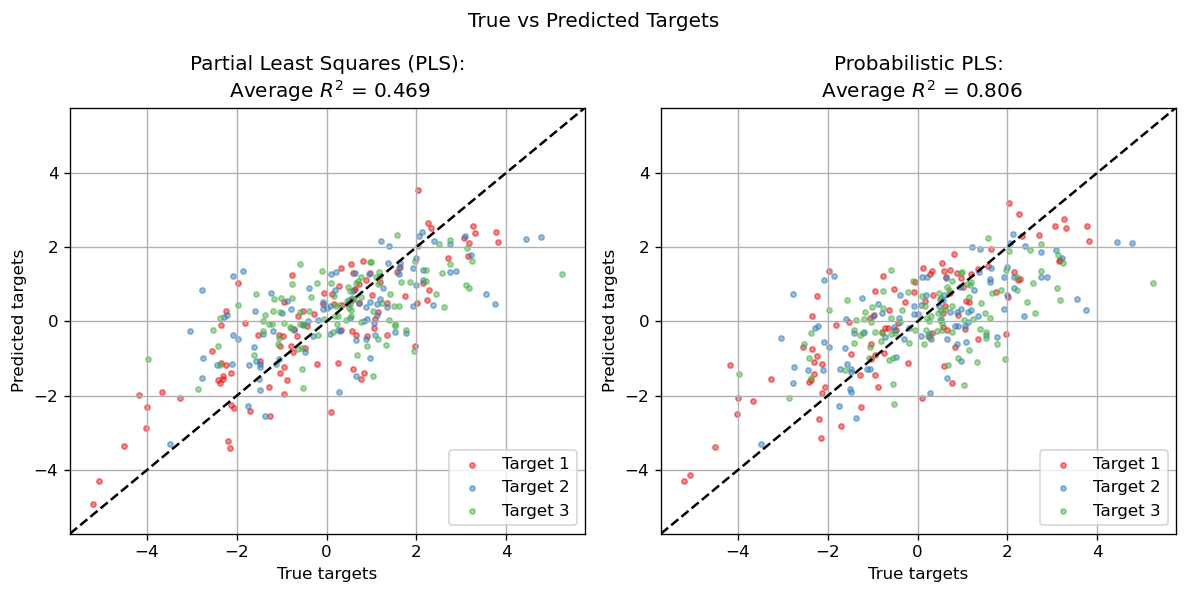

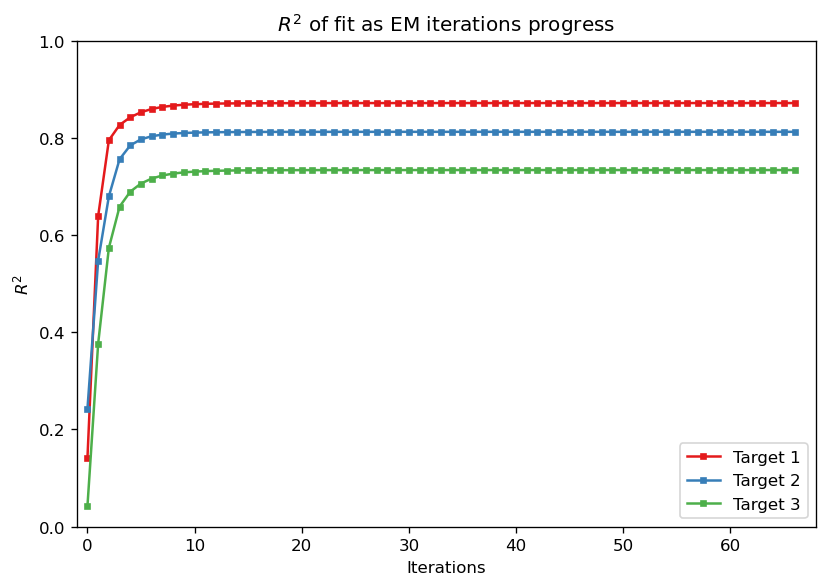

In [27]:
# Obtain ranges, colormaps and names for the plots
def variable_plot_range(x, percentage = 0.05):
    min_value = np.min(x)
    max_value = np.max(x)
    range_value = max_value - min_value
    adjustment = percentage * range_value
    return (min_value - adjustment, max_value + adjustment)
y_range = variable_plot_range(Y)
all_range = variable_plot_range([Y, Y_pred_pls, Y_pred_ppls, Y_pred_stacked_standardized, Y_pred_stacked_raw])
axis_range = [*all_range, *all_range]
colors = plt.colormaps["Set1"]
names = ["Target " + str(i+1) for i in range(q)]

# Visualization of true vs. tredicted responses
plt.figure(figsize=(10, 5), dpi=120)
plt.suptitle("True vs Predicted Targets")

# PLS regression
plt.subplot(1, 2, 1)
for i in range(q):
    plt.scatter(Y[:, i], Y_pred_pls[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(y_range, y_range, "k--")
plt.axis(axis_range)
plt.title(f'Partial Least Squares (PLS):\n Average $R^2$ = {np.mean(r2_pls):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# # Probabilistic PLS
# plt.subplot(2, 2, 2)
# for i in range(q):
#     plt.scatter(Y[:, i], Y_pred_ppls[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
# plt.plot(y_range, y_range, "k--")
# plt.axis(axis_range)
# plt.title(f'Probabilistic PLS:\n Average $R^2$ = {np.mean(r2_ppls):.2f}')
# # plt.xlabel('True $Y$')
# # plt.ylabel('Predicted $Y$')
# plt.legend(loc="lower right")
# plt.grid(True)

# # Stacked Probabilistic PLS (After standardization)
# plt.subplot(2, 2, 3)
# for i in range(q):
#     plt.scatter(Y[:, i], Y_pred_stacked_standardized[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
# plt.plot(y_range, y_range, "k--")
# plt.axis(axis_range)
# plt.title(f'Probabilistic PLS Stacked (Standardized):\n Average $R^2$ = {np.mean(r2_stacked_standardized):.2f}')
# plt.xlabel('True $Y$')
# plt.ylabel('Predicted $Y$')
# plt.legend(loc="lower right")
# plt.grid(True)

# Stacked Probabilistic PLS (Without standardization)
plt.subplot(1, 2, 2)
for i in range(q):
    plt.scatter(Y[:, i], Y_pred_stacked_raw[:, i], alpha=0.5, color=colors(i), s=10, label=names[i])
plt.plot(y_range, y_range, "k--")
plt.axis(axis_range)
plt.title(f'Probabilistic PLS:\n Average $R^2$ = {np.mean(r2_stacked_raw):.3f}')
plt.xlabel('True targets')
plt.ylabel('Predicted targets')
plt.legend(loc="lower right")
plt.grid(True)

# Save resulting plot
plt.tight_layout()
plt.savefig('single_fit_comparison.png', bbox_inches='tight')
plt.show()

# Plot path of R-squared in stacked PPLS
max_iterations = max([stacked_model_standardized.r2_array_.shape[0], stacked_model_raw.r2_array_.shape[0]])
plt.figure(figsize=(7, 5), dpi=120)
plt.title("$R^2$ of fit as EM iterations progress")
# plt.subplot(1, 2, 1)
# for i in range(q):
#     plt.plot(stacked_model_standardized.r2_array_[:, i], "s-", color=colors(i), label=names[i], markersize=3)
# plt.axis([-1, max_iterations+1, 0, 1])
# plt.title("PPLS after Standardization")
# plt.xlabel("Iterations")
# plt.ylabel("$R^2$")
# plt.legend(loc="lower right")

# plt.subplot(1, 2, 2)
for i in range(q):
    plt.plot(stacked_model_raw.r2_array_[:, i], "s-", color=colors(i), label=names[i], markersize=3)
plt.axis([-1, max_iterations+1, 0, 1])
plt.xlabel("Iterations")
plt.ylabel("$R^2$")
plt.legend(loc="lower right")

plt.tight_layout()
plt.savefig('rsquared_em_iterations.png', bbox_inches='tight')
plt.show()

In [28]:
# Exploration of differences between stacked and unstacked
max_iter = 1000
tolerance = 1e-6
standardize = False

# One loop of unstacked EM
P = np.random.randn(p, k)
Q = np.random.randn(q, k)
sigma_x = np.var(X, axis=0).mean()  # Mean variance across features
sigma_y = np.var(Y, axis=0).mean()  # Mean variance across targets

# E-step: Compute posterior mean M and covariance Sigma
A = (P.T @ P) / sigma_x + (Q.T @ Q) / sigma_y + np.eye(k)
Sigma_unstacked = np.linalg.inv(A)
B = (X @ P) / sigma_x + (Y @ Q) / sigma_y
M_unstacked = np.linalg.solve(A, B.T).T

# M-step: Update P, Q, sigma_x, and sigma_y
V_new = M_unstacked.T @ M_unstacked + n * Sigma_unstacked
P_new = (X.T @ M_unstacked) @ np.linalg.inv(V_new)
Q_new = (Y.T @ M_unstacked) @ np.linalg.inv(V_new)
sigma_x_new = (1 / (n * p)) * (np.linalg.norm(X - M_unstacked @ P_new.T, 'fro')**2) + (1 / p) * np.trace(P_new.T @ P_new @ Sigma_unstacked)
sigma_y_new = (1 / (n * q)) * (np.linalg.norm(Y - M_unstacked @ Q_new.T, 'fro')**2) + (1 / q)  * np.trace(Q_new.T @ Q_new @ Sigma_unstacked)

P_distance = np.linalg.norm(P - P_new, "fro")
Q_distance = np.linalg.norm(Q - Q_new, "fro")
sigma_x_distance = abs(sigma_x - sigma_x_new)
sigma_y_distance = abs(sigma_y - sigma_y_new)
theta_distance_unstacked = P_distance + Q_distance + sigma_x_distance + sigma_y_distance

convergence_unstacked = (P_distance < tolerance and Q_distance < tolerance
                         and sigma_x_distance < tolerance and sigma_y_distance < tolerance)

# One loop of stacked EM
d = p + q
rng = np.random.default_rng(seed=seed_value)
V_prior_inv = np.eye(k)
L0 = np.vstack([P, Q])
sigma2_x0 = sigma_x
sigma2_y0 = sigma_y
if standardize:
    X = (X - X.mean(axis = 0)) / X.std(axis = 0)
    Y = (Y - Y.mean(axis = 0)) / Y.std(axis = 0)
Z = np.hstack([X, Y])

# Expectation step: Update posterior paramater for factors
L_scaled = np.vstack([L0[:p] / sigma2_x0, L0[p:] / sigma2_y0])
Sigma_stacked = np.linalg.inv(V_prior_inv + L0.T @ L_scaled)
M_stacked = Z @ L_scaled @ Sigma_stacked

# Maximization step: Update factor loadings and variances
V = n * Sigma_stacked + M_stacked.T @ M_stacked
L1 = np.linalg.solve(V, M_stacked.T @ Z).T
P = L1[:p]
Q = L1[p:]
sigma2_x1 = (1/(n * p)) * (np.trace(X.T @ X) - np.trace(P.T @ P @ V))
sigma2_y1 = (1/(n * q)) * (np.trace(Y.T @ Y) - np.trace(Q.T @ Q @ V))

# Compute distance between iterates
P_distance = np.linalg.norm(P - L0[:p], "fro")
Q_distance = np.linalg.norm(Q - L0[p:], "fro")
sigma_x_distance = np.abs(sigma2_x1 - sigma2_x0)
sigma_y_distance = np.abs(sigma2_y1 - sigma2_y0)
theta_distance_stacked = sum([P_distance, Q_distance, sigma_x_distance, sigma_y_distance])

# Comparison
print(Sigma_unstacked); print(Sigma_stacked)
print(M_unstacked); print(M_stacked)
print(P_new); print(P)
print(Q_new); print(Q)
print(sigma_x_new); print(sigma2_x1)
print(sigma_y_new); print(sigma2_y1)
print(theta_distance_unstacked); print(theta_distance_stacked)

# Comparison of predictions
Y_hat_unstacked = M_unstacked @ Q_new.T
Y_hat_stacked = M_stacked @ Q.T
r2_unstacked = r2_score(Y, Y_hat_unstacked, multioutput = "raw_values")
r2_stacked = r2_score(Y, Y_hat_stacked, multioutput = "raw_values")
print(r2_unstacked); print(r2_stacked)

# One loop of DFM - EM
# X is T x p; Y is T x q; Factors assumed as T x k
T, p = X.shape
_, q = Y.shape
d = p + q

# Initial values for the parameters
L0 = np.random.default_rng().normal(size = [d, k])
sigma2_x0 = np.var(X, axis = 0).mean()    # Mean variance across features
sigma2_y0 = np.var(Y, axis = 0).mean()    # Mean variance across targets
A0 = np.eye(k)
f0 = np.zeros(k)

# Expectation step: Update posterior paramater for factors using sparse matrix computations
L_scaled = np.vstack([L0[:p] / sigma2_x0, L0[p:] / sigma2_y0])
L_scaled_L = L0.T @ L_scaled
Sigma_v_A = - np.eye(k) @ A0
A_Sigma_v_A = - A0.T @ Sigma_v_A
Omega_0_inv = np.eye(k) + A_Sigma_v_A + L_scaled_L

# Save posterior precision as a sparse matrix
main_diagonal = sparse.kron(sparse.eye(T, format='csr'), Omega_0_inv)
lower_diagonal = sparse.kron(sparse.eye(T, k=-1, format='csr'), Sigma_v_A)
last_block = sparse.lil_matrix((T * k, T * k))  # Create an empty sparse matrix of the same size
last_block[(T-1)*k : T*k, (T-1)*k : T*k] = np.eye(k) + L_scaled_L
Omega_inv_sparse = sparse.tril(main_diagonal + lower_diagonal + last_block)

# Save posterior precision to a symmetric banded matrix and compute its Cholesky decomposition
# (Tk x Tk) -> (2k x Tk), only storing the 2k lower diagonal bands
Omega_inv_cholesky = np.zeros([2 * k, T * k])
for diagonal in range(2 * k):
    Omega_inv_cholesky[diagonal, :(T * k - diagonal)] = Omega_inv_sparse.diagonal(-diagonal)
Omega_inv_cholesky = linalg.cholesky_banded(Omega_inv_cholesky, overwrite_ab=True, lower=True)

# Posterior mean matrix
M = np.ravel(Z @ L_scaled)
M[:k] = M[:k] - Sigma_v_A @ f0
M = linalg.cho_solve_banded((Omega_inv_cholesky, True), b = M, overwrite_b=True).reshape([T, k])
print(M)

# Calculate banded elements of the posterior covariance using lower-level function
desired_bands = 3 * k - 1
lower_bandwidth = Omega_inv_cholesky.shape[0] - 1
total_rows = 2 * desired_bands + 1
Omega_banded = np.zeros([total_rows, T * k])

# Transform Cholesky decomposition to LDL' decomposition
cholesky_diagonal = Omega_inv_cholesky[0]                 # Given banded structure, diagonal is first row
cholesky_banded = Omega_inv_cholesky / cholesky_diagonal  # Columns are also in place, so can simply divide to invert
cholesky_diagonal = 1 / cholesky_diagonal**2

# Main algorithm loop
bandwidth_range = range(1, lower_bandwidth+1)
for j in reversed(range(T * k)):
    for i in reversed(range(max(j - desired_bands - 1, 0), j)):
        save_row_index = desired_bands + i - j
        next_row_index = range(min(save_row_index + 1, total_rows - 1),
                               min(save_row_index + lower_bandwidth + 1, total_rows - 1))
        Omega_banded[save_row_index, j] = -np.dot(cholesky_banded[bandwidth_range, i], Omega_banded[next_row_index, j])
        Omega_banded[min(desired_bands + j - i, total_rows - 1), i] = Omega_banded[save_row_index, j]
        if i == j:
            Omega_banded[save_row_index, i] += cholesky_diagonal[i]

# Discard upper set of elements and obtain sums over block diagonal elements
Omega_banded = Omega_banded[desired_bands:, :]
required_blocks = 3    # Diagonal block + two lower diagonal blocks
sum_array = np.zeros([required_blocks, k, k])
for block in range(required_blocks):
    for j in range(k):
        if block == 0:
            # Compute lower-diagonal block of V_0 = sum_{t=1}^{T} Omega_{t, t}
            sum_array[0][j:, j] = np.sum(Omega_banded[np.ix_(range(k - j), range(j, T * k, k))], axis = 1)
        else:
            # Compute Bar_Omega_j = sum_{t=j}^{T-1} Omega_{t - j, t}
            row_index = range(block * k - j, (block+1) * k - j)
            column_index = range(j, (T - block) * k, k)
            sum_array[block][:, j] = np.sum(Omega_banded[np.ix_(row_index, column_index)], axis = 1)
sum_array[0][np.triu_indices(k, 1)] = sum_array[0][np.tril_indices(k, -1)]  # Fill-in missing block

# Update loadings and error variances
V_0 = sum_array[0] + M.T @ M
L1 = np.linalg.solve(V_0, M.T @ Z).T
P = L1[:p]
Q = L1[p:]
sigma2_x1 = (1/(T * p)) * (np.sum(X**2) - np.trace(P.T @ P @ V_0))
sigma2_y1 = (1/(T * q)) * (np.sum(Y**2) - np.trace(Q.T @ Q @ V_0))

# Update dynamic parameters: Autoregressive coefficients and initial condition
V_1 = sum_array[1] + M[:(T-1)].T @ M[1:]
V_2 = sum_array[2] + M[:(T-2)].T @ M[2:]
A1 = np.linalg.solve(V_2, V_1)
f0_1 = np.linalg.solve(A1.T @ A1, A1.T @ M[0])

# Print results
print(P)
print(Q)
print(sigma2_x1)
print(sigma2_y1)

[[0.26972735 0.05607474]
 [0.05607474 0.26785916]]
[[0.26972735 0.05607474]
 [0.05607474 0.26785916]]
[[-0.44024694 -0.35385218]
 [-0.02022586  0.07287305]
 [ 0.24969911  0.10947601]
 [ 0.35615393  0.3070685 ]
 [ 0.01761405  0.33311684]
 [-0.17965594 -0.20940027]
 [ 0.16605751 -0.78179326]
 [ 0.464849    0.34999436]
 [-0.04938827  0.478611  ]
 [-0.41774067 -0.22874422]
 [ 0.25930259  0.47124716]
 [-0.26828936 -0.18334044]
 [ 0.19299375  0.19645531]
 [ 0.17002393  0.30698543]
 [-0.85216014 -0.31389834]
 [-0.03210353 -0.08046321]
 [-0.30460097  0.35534141]
 [ 0.44313741  0.69175026]
 [ 0.40115728  0.18765016]
 [ 0.54528147  0.4198173 ]
 [ 0.03849192  0.33476007]
 [-0.81560264 -0.82753442]
 [ 0.01704637 -0.0051264 ]
 [ 0.61986017  0.11775483]
 [ 0.37585849 -0.0373757 ]
 [ 0.55396896  0.00768882]
 [-0.20947636  0.0340268 ]
 [ 0.36171103  0.43864577]
 [-0.0240119  -0.15974033]
 [-0.13096605  0.09451227]
 [ 0.29702085  0.13710518]
 [-0.00581498 -0.09300096]
 [ 0.1457639   0.46763375]
 [ 0.23

In [29]:
# Function to evaluate models over a range of noise levels
def evaluate_models_over_noise(n, p, q, k, noise_levels, n_replications):
    n_levels = len(noise_levels)
    r2_pls_results = np.zeros([n_levels, n_levels, n_replications])
    # r2_ppls_results = np.zeros([n_levels, n_levels, n_replications])
    r2_stacked_results = np.zeros([n_levels, n_levels, n_replications])

    for i, sigma_x in enumerate(noise_levels):
        for j, sigma_y in enumerate(noise_levels):
            for l in range(n_replications):
                # Generate synthetic data
                X, Y, _, _, _ = generate_synthetic_data(n, p, q, k, sigma_x, sigma_y, seed_value=None)
                
                # Apply PLS regression
                pls = PLSRegression(n_components=k)
                pls.fit(X, Y)
                Y_pred_pls = pls.predict(X)

                # # Apply PPLS
                # ppls_model = ProbabilisticPLS(n_components=k)
                # ppls_model.fit(X, Y)
                # Y_pred_ppls = ppls_model.predict(X)

                # Apply stacked PPLS
                stacked_model = ProbabilisticPLS(n_components=k)
                stacked_model.fit(X, Y, standardize=False, track_r2=False)
                Y_pred_stacked = stacked_model.fitted(X, Y, standardize=False)

                # Compute R-squared for both models
                r2_pls_results[i, j, l] = r2_score(Y, Y_pred_pls)
                # r2_ppls_results[i, j, l] = r2_score(Y, Y_pred_ppls)
                r2_stacked_results[i, j, l] = r2_score(Y, Y_pred_stacked)

    return r2_pls_results, r2_stacked_results # , r2_ppls_results

# Evaluate models
n_replications = 100
noise_levels = np.linspace(0.1, 5, 20)
r2_pls_results, r2_stacked_results = evaluate_models_over_noise(n, p, q, k, noise_levels, n_replications)


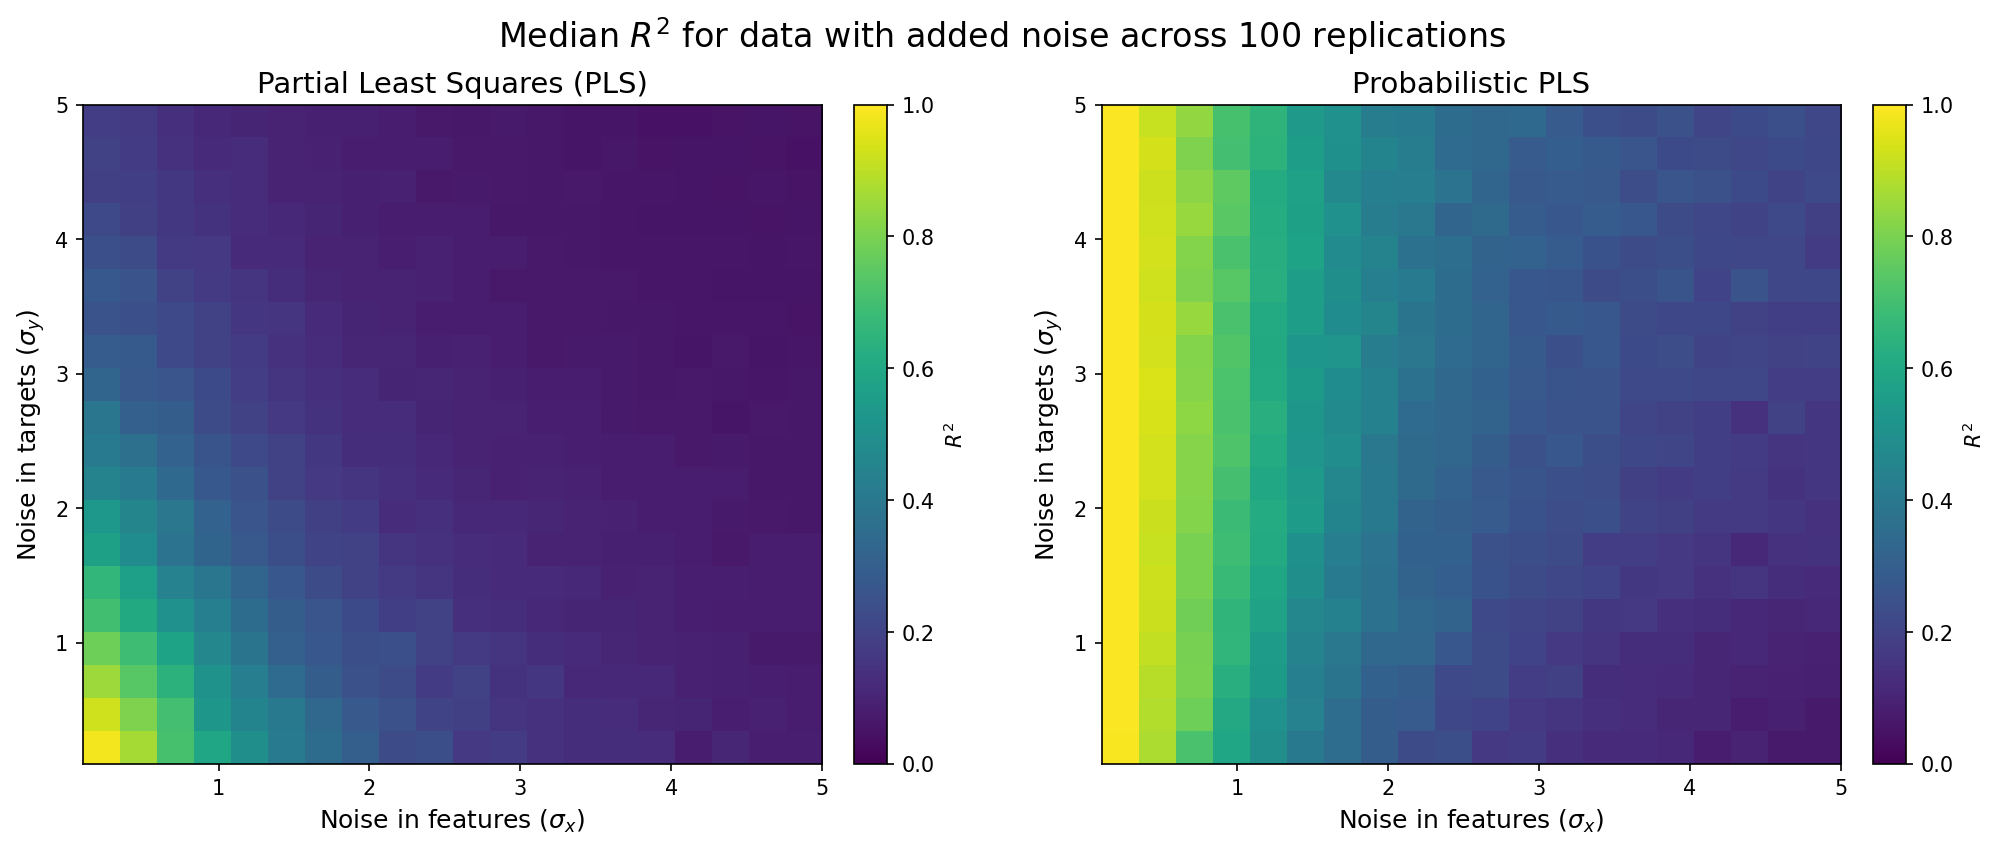

In [30]:
# Compute statistics across replications
r2_pls_median = np.median(r2_pls_results, axis = 2)
# r2_ppls_median = np.median(r2_ppls_results, axis = 2)
r2_stacked_median = np.median(r2_stacked_results, axis = 2)
tick_locations = np.linspace(0, 1, 11)

# Visualize results as heatmaps
plt.figure(figsize=(14, 6), dpi=150)
plt.suptitle("Median $R^2$ for data with added noise across " + str(n_replications) + " replications", fontsize = 16)

# PLS R-squared heatmap
plt.subplot(1, 2, 1)
im1 = plt.imshow(r2_pls_median, origin='lower', cmap='viridis', vmin=0, vmax=1, aspect='auto',
                 extent=[noise_levels.min(), noise_levels.max(), noise_levels.min(), noise_levels.max()])
cbar1 = plt.colorbar(im1, label='$R^2$', fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=10)
plt.title('Partial Least Squares (PLS)', fontsize=14)
plt.xlabel('Noise in features ($\\sigma_x$)', fontsize=12)
plt.ylabel('Noise in targets ($\\sigma_y$)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# # PPLS R-squared heatmap
# plt.subplot(1, 3, 2)
# im1 = plt.imshow(r2_ppls_median, origin='lower', cmap='viridis', aspect='auto',
#                  extent=[noise_levels.min(), noise_levels.max(), noise_levels.min(), noise_levels.max()])
# cbar1 = plt.colorbar(im1, label='$R^2$', fraction=0.046, pad=0.04)
# cbar1.ax.tick_params(labelsize=10)
# plt.title('PPLS R-squared', fontsize=14)
# plt.xlabel('Noise in $X$ ($\sigma_x$)', fontsize=12)
# plt.ylabel('Noise in $Y$ ($\sigma_y$)', fontsize=12)
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)

# Stacked PPLS R-squared heatmap
plt.subplot(1, 2, 2)
im2 = plt.imshow(r2_stacked_median, origin='lower', cmap='viridis', vmin=0, vmax=1, aspect='auto',
                 extent=[noise_levels.min(), noise_levels.max(), noise_levels.min(), noise_levels.max()])
cbar2 = plt.colorbar(im2, label='$R^2$', fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=10)
plt.title('Probabilistic PLS', fontsize=14)
plt.xlabel('Noise in features ($\\sigma_x$)', fontsize=12)
plt.ylabel('Noise in targets ($\\sigma_y$)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.88)
plt.savefig('noise_comparison_heatmap.png', bbox_inches='tight')
plt.show()

[3.206544451505305, 6.952891147080326]
[[0.20077109]
 [0.19233461]
 [0.16494371]
 [0.14094815]
 [0.12691018]
 [0.12151714]
 [0.12083752]
 [0.12221325]
 [0.12442474]
 [0.12697094]
 [0.12963877]
 [0.13232827]
 [0.13498717]
 [0.13758533]
 [0.14010377]
 [0.14252959]
 [0.1448535 ]
 [0.14706859]
 [0.14916982]
 [0.15115372]
 [0.15301832]
 [0.15476305]
 [0.15638865]
 [0.15789712]
 [0.15929151]
 [0.1605758 ]
 [0.16175473]
 [0.16283359]
 [0.16381809]
 [0.16471416]
 [0.16552784]
 [0.16626516]
 [0.16693202]
 [0.16753414]
 [0.16807699]
 [0.16856575]
 [0.16900529]
 [0.16940014]
 [0.16975453]
 [0.17007234]
 [0.17035714]
 [0.17061219]
 [0.17084047]
 [0.17104469]
 [0.1712273 ]
 [0.17139052]
 [0.17153636]
 [0.17166663]
 [0.17178296]
 [0.17188682]
 [0.17197951]
 [0.17206223]
 [0.17213604]
 [0.17220188]
 [0.1722606 ]
 [0.17231297]
 [0.17235967]
 [0.17240131]
 [0.17243843]
 [0.17247152]
 [0.17250101]
 [0.1725273 ]
 [0.17255073]
 [0.17257161]
 [0.17259022]
 [0.1726068 ]
 [0.17262157]
 [0.17263473]
 [0.17264

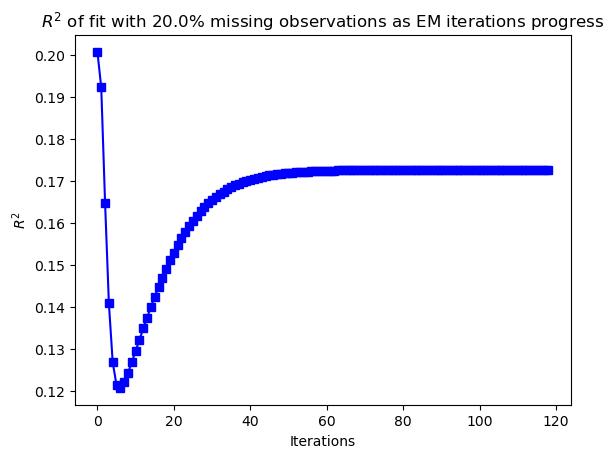

In [31]:
# Load new functions to deal with missing data
from PPLS import generate_synthetic_missing_data

# Generate data
proportion = 0.2
X, Y, F, P, Q = generate_synthetic_missing_data(n, p, q, k, sigma_x, sigma_y, proportion)

# Estimate PPLS imputing missing data within EM algorithm
ppls_missing_model = ProbabilisticPLS(n_components=k)
ppls_missing_model.fit(X, Y, standardize=False, track_r2=True)
print([ppls_missing_model.sigma2_x_, ppls_missing_model.sigma2_y_])
print(ppls_missing_model.r2_array_)

# Plot path of R-squared
plt.figure()
plt.plot(ppls_missing_model.r2_array_, "s-b")
plt.title("$R^2$ of fit with " + str(100*proportion) + "% missing observations as EM iterations progress")
plt.xlabel("Iterations")
plt.ylabel("$R^2$")
plt.show()

In [32]:
# Function to evaluate models over a range of percentage of missing observations
def evaluate_models_over_missing(n, p, q, k, missing_levels, n_replications):
    n_levels = len(missing_levels)
    r2_pls_full = np.zeros([n_levels, n_levels, n_replications])
    r2_ppls_full = np.zeros([n_levels, n_levels, n_replications])
    r2_missing_full = np.zeros([n_levels, n_levels, n_replications])
    r2_pls_imputed = np.zeros([n_levels, n_levels, n_replications])
    r2_ppls_imputed = np.zeros([n_levels, n_levels, n_replications])
    r2_missing_imputed = np.zeros([n_levels, n_levels, n_replications])

    for i, proportion_x in enumerate(missing_levels):
        for j, proportion_y in enumerate(missing_levels):
            for l in range(n_replications):
                # Generate synthetic data
                X, Y, _, _, _ = generate_synthetic_missing_data(n, p, q, k, sigma_x, sigma_y,
                                                                proportion_x, proportion_y, seed_value=None, return_nan=False)
                
                # Create imputed copies to compare with standard PLS and PPLS
                X_imputed = X.filled()
                Y_imputed = Y.filled()
                Y_full = np.copy(Y.data)
                
                # Apply PLS regression
                pls = PLSRegression(n_components=k)
                pls.fit(X_imputed, Y_imputed)
                Y_pred_pls = pls.predict(X_imputed)

                # Apply PPLS
                ppls_model = ProbabilisticPLS(n_components=k)
                ppls_model.fit(X_imputed, Y_imputed, standardize=False, track_r2=False)
                Y_pred_ppls = ppls_model.fitted(X_imputed, Y_imputed, standardize=False)

                # Apply PPLS with missing data
                X.data[X.mask] = np.nan
                Y.data[Y.mask] = np.nan
                missing_model = ProbabilisticPLS(n_components=k)
                missing_model.fit(X.data, Y.data, standardize=False, track_r2=False)
                Y_pred_missing = missing_model.fitted(X.data, Y_imputed, standardize=False)

                # Compute R-squared for all models (with respect to full matrix)
                r2_pls_full[i, j, l] = r2_score(Y_full, Y_pred_pls)
                r2_ppls_full[i, j, l] = r2_score(Y_full, Y_pred_ppls)
                r2_missing_full[i, j, l] = r2_score(Y_full, Y_pred_missing)

                # Compute R-squared for all models (with respect to imputed matrix)
                r2_pls_imputed[i, j, l] = r2_score(Y_imputed, Y_pred_pls)
                r2_ppls_imputed[i, j, l] = r2_score(Y_imputed, Y_pred_ppls)
                r2_missing_imputed[i, j, l] = r2_score(Y_imputed, Y_pred_missing)


    return r2_pls_full, r2_ppls_full, r2_missing_full, r2_pls_imputed, r2_ppls_imputed, r2_missing_imputed

# Provide levels of missing observations and run function
n_replications = 100
missing_levels = np.linspace(0.0, 0.5, 20)
r2_pls_full, r2_ppls_full, r2_missing_full, r2_pls_imputed, r2_ppls_imputed, r2_missing_imputed = evaluate_models_over_missing(n, p, q, k, missing_levels, n_replications)

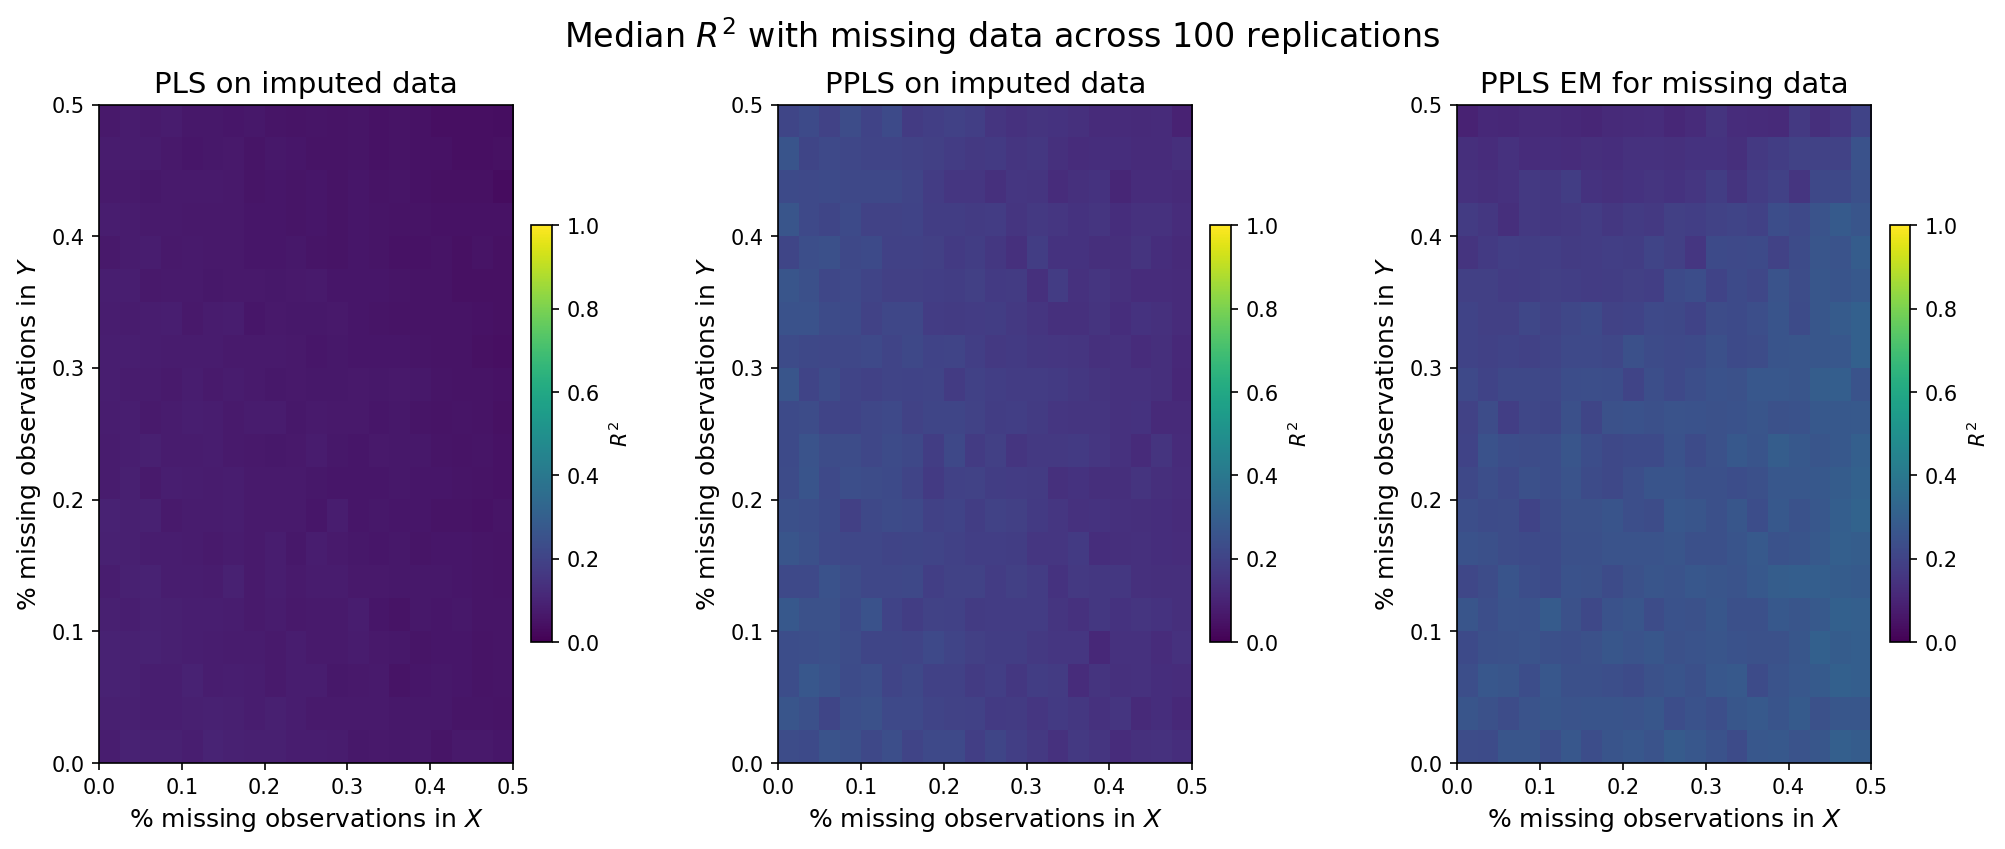

In [33]:
# Compute statistics across replications
r2_pls_full_median = np.median(r2_pls_full, axis = 2)
r2_ppls_full_median = np.median(r2_ppls_full, axis = 2)
r2_missing_full_median = np.median(r2_missing_full, axis = 2)
r2_pls_imputed_median = np.median(r2_pls_imputed, axis = 2)
r2_ppls_imputed_median = np.median(r2_ppls_imputed, axis = 2)
r2_missing_imputed_median = np.median(r2_missing_imputed, axis = 2)

# Visualize results as heatmaps
plt.figure(figsize=(14, 6), dpi=150)
plt.suptitle("Median $R^2$ with missing data across " + str(n_replications) + " replications", size = 16)
missing_range = variable_plot_range(missing_levels, percentage = 0)
missing_extent = [*missing_range, *missing_range]

# PLS R-squared heatmap
plt.subplot(1, 3, 1)
im2 = plt.imshow(r2_pls_full_median, origin='lower', cmap='viridis', vmin=0, vmax=1, aspect='auto', extent=missing_extent)
cbar2 = plt.colorbar(im2, label='$R^2$', fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=10)
plt.title('PLS on imputed data', fontsize=14)
plt.xlabel('% missing observations in $X$', fontsize=12)
plt.ylabel('% missing observations in $Y$', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# PPLS R-squared heatmap
plt.subplot(1, 3, 2)
im1 = plt.imshow(r2_ppls_full_median, origin='lower', cmap='viridis', vmin=0, vmax=1, aspect='auto', extent=missing_extent)
cbar1 = plt.colorbar(im1, label='$R^2$', fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=10)
plt.title('PPLS on imputed data', fontsize=14)
plt.xlabel('% missing observations in $X$', fontsize=12)
plt.ylabel('% missing observations in $Y$', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Stacked PPLS R-squared heatmap
plt.subplot(1, 3, 3)
im1 = plt.imshow(r2_missing_full_median, origin='lower', cmap='viridis', vmin=0, vmax=1, aspect='auto', extent=missing_extent)
cbar1 = plt.colorbar(im1, label='$R^2$', fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=10)
plt.title('PPLS EM for missing data', fontsize=14)
plt.xlabel('% missing observations in $X$', fontsize=12)
plt.ylabel('% missing observations in $Y$', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.88)
plt.savefig('missing_comparison_heatmap.png', bbox_inches='tight')
plt.show()